## Import Library

In [ ]:
# Import Library yang akan digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown
import plotly.graph_objects as go
import plotly.offline as py
import joblib
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc

## Pre Processing Data

### Gathering Data

In [ ]:
# Baca Dataset
df = pd.read_csv("/content/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


**Insight**

Pada tahapan Gathering Data ini kami mengambil dataset dari Kaggle yang kemudian kmi upload ke Gdrive, untuk memudahkan akses dan pengelolaan. Dataset yang digunakan adalah dataset Pima Indians Diabetes Database, yang merupakan dataset populer untuk analisis prediksi penyakit diabetes.

### Asessing Data

In [ ]:
#Infromasi Dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
#Cek Data Null
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
# Describe Fitur Numerik
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Cek Jumlah Kolom
rows = df.shape[0]
cols = df.shape[1]
print("Rows   : " + str(rows))
print("Columns: " + str(cols))

Rows   : 768
Columns: 9


In [ ]:
# Check duplicate data
print("Number of duplicates: " + str(df.duplicated().sum()))

Number of duplicates: 0


In [ ]:
# Number of unique values per column.
df.nunique()

,0
Pregnancies,17
Glucose,136
BloodPressure,47
SkinThickness,51
Insulin,186
BMI,248
DiabetesPedigreeFunction,517
Age,52
Outcome,2


In [ ]:
Counter(df['Outcome'])

Counter({1: 268, 0: 500})

**Insight**

Pada bagian Asesing Data ini kami menemukan bahwa dataset yang terdiri dari 768 baris dan 9 kolom (8 fitur dan 1 target Outcome) tampak lengkap tanpa nilai NaN, namun mengandung nilai 0 pada fitur seperti `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, dan `BMI` yang secara medis tidak realistis, sehingga perlu dianggap sebagai missing values terselubung. Kami juga menemukan bahwa dataset ini tidak meimiliki redundansi, kemudian variasi nilai unik yang tinggi pada fitur kontinu seperti Glucose menawarkan informasi kaya untuk modeling.


### Cleaning Data

#### Replace 0 to NaN

Pada Dataset ini ditemukan bahwa banyak data yang 0, yang mana hal itu tidak mungkin terjadi, karena data seperti Tekanan Darah, Insulin, tidak mungkin bernilai 0.
Oleh karena itu, data ini adalah missing values dan akan diganti dengan NaN. Pada dataset ini kami mengganti nilai 0 dalam kolom Glucose, BloodPressure, SkinThickness, Insulin, dan BMI dengan NaN.

In [ ]:
# Replace 0 with np.nan (lowercase 'nan') to treat them as missing values
cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols] = df[cols].where(df[cols] != 0, np.nan)


**Insight**

 Pada bagian ini kami memvisualisasikan jumlah missing values (nilai yang hilang) dalam suatu dataset menggunakan plot batang (bar chart) dari library Plotly.

In [ ]:
def missing_plot(df, key):
    total = df.shape[0]
    missing_count = df.isnull().sum()
    filled_count = total - missing_count
    missing_pct = (missing_count / total * 100).round(2)

    trace = go.Bar(
        x=df.columns,
        y=filled_count,
        text=missing_pct,
        textposition='auto',
        opacity=0.8,
        marker=dict(color='#7EC0EE', line=dict(color='#000000', width=1.5))
    )

    layout = go.Layout(title="Missing Values (count & %)")
    fig = go.Figure(data=[trace], layout=layout)
    py.iplot(fig)

# Plotting
missing_plot(df, 'Outcome')


#### Replacing Missing Value
**Insight**

Setelah data 0 yang tidak masuk akal diubah ke NaN, maka searang kita memiliki data yang missing value. Pada bagian ini kami melakukan pengubahan missing value menjadi data yang nilainya merupakan median untuk masing-masing outcome.

Misalnya data median untuk Glucose dengan target 0 (Healthy) adalah 107. Sedangkan untuk target 1 (Diabetes) itu adalah 140. Kemudian nilai Glukosa 0 yang memiliki target 0 itu akan diganti ke 107 dan yang target 1 akan diganti ke 140.

Hal ini kami lakukan agar datanya menjadi lebih cocok untuk masing-masing outcome.

In [ ]:
def median_target(var): # Membuang data yang memiliki nilai NaN pada kolom tertentu
    temp = df[df[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index() #Mengelompokkan data berdasarkan kelas target ('Outcome')
    return temp

### 3.1 Insulin
**Insight**

Pada bagian insulin ini kami mengubah data missing valuenya menjadi median untuk masing-masing outcome. Untuk data yang outcomenya adalah 0, nilai median adalah 102.5 , sedangkan untuk data insulin dengan outcome 1(diabetes), nilai median adalah 169.5

In [ ]:
def plot_distribution(feature, bin_size):
    # Pisahkan data berdasarkan Outcome
    grouped = df.groupby('Outcome')
    diabetic = grouped.get_group(1)[feature].dropna().tolist()
    healthy = grouped.get_group(0)[feature].dropna().tolist()

    # Siapkan data untuk plot
    data = [diabetic, healthy]
    labels = ['Diabetic', 'Healthy']
    colors = ['#FFD700', '#7EC0EE']

    # Buat density plot
    fig = ff.create_distplot(
        data, labels, colors=colors, show_hist=True, bin_size=bin_size, curve_type='kde'
    )

    fig.update_layout(title_text=f'Distribution of {feature}', title_x=0.5)

    py.iplot(fig)

# Contoh pemanggilan
plot_distribution('Insulin', 5)


In [ ]:
median_target('Insulin')

Median 'Insulin' untuk setiap Outcome:
Outcome
0    102.5
1    169.5
Name: Insulin, dtype: float64


bertujuan untuk menghitung nilai median dari kadar Insulin berdasarkan kelas target ('Outcome') dalam dataset df.

In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['Insulin'].isnull()), 'Insulin'] = 102.5
df.loc[(df['Outcome'] == 1 ) & (df['Insulin'].isnull()), 'Insulin'] = 169.5

Kode ini digunakan untuk mengisi (imputasi) nilai NaN dalam kolom Insulin berdasarkan kelas Outcome (sehat atau diabetes) dengan nilai median masing-masing kelompok.

### 3.2 Glukosa
**Insight**

Pada bagian Glucose ini kami mengubah data missing valuenya menjadi median untuk masing-masing outcome. Untuk data yang outcomenya adalah 0, nilai median adalah 107 , sedangkan untuk data insulin dengan outcome 1(diabetes), nilai median adalah 140

In [ ]:
plot_distribution('Glucose', 0)

In [ ]:
median_target('Glucose')

Median 'Glucose' untuk setiap Outcome:
Outcome
0    107.0
1    140.0
Name: Glucose, dtype: float64


In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['Glucose'].isnull()), 'Glucose'] = 107
df.loc[(df['Outcome'] == 1 ) & (df['Glucose'].isnull()), 'Glucose'] = 140

### 3.3 SkinThickness
**Insight**

Pada bagian SkinThickness ini kami mengubah data missing valuenya menjadi median untuk masing-masing outcome. Untuk data yang outcomenya adalah 0, nilai median adalah 27.0 , sedangkan untuk data insulin dengan outcome 1(diabetes), nilai median adalah 32.0

In [ ]:
plot_distribution('SkinThickness', 10)

In [ ]:
median_target('SkinThickness')

Median 'SkinThickness' untuk setiap Outcome:
Outcome
0    27.0
1    32.0
Name: SkinThickness, dtype: float64


In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 27
df.loc[(df['Outcome'] == 1 ) & (df['SkinThickness'].isnull()), 'SkinThickness'] = 32

### 3.4 BloodPressure
**Insight**

Pada bagian SkinThickness ini kami mengubah data missing valuenya menjadi median untuk masing-masing outcome. Untuk data yang outcomenya adalah 0, nilai median adalah 70.0 , sedangkan untuk data insulin dengan outcome 1(diabetes), nilai median adalah 74.5

In [ ]:
plot_distribution('BloodPressure', 5)

In [ ]:
median_target('BloodPressure')

Median 'BloodPressure' untuk setiap Outcome:
Outcome
0    70.0
1    74.5
Name: BloodPressure, dtype: float64


In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 70
df.loc[(df['Outcome'] == 1 ) & (df['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

### 3.5 BMI
**Insight**

Pada bagian SkinThickness ini kami mengubah data missing valuenya menjadi median untuk masing-masing outcome. Untuk data yang outcomenya adalah 0, nilai median adalah 30.1 , sedangkan untuk data insulin dengan outcome 1(diabetes), nilai median adalah 34.3

In [ ]:
plot_distribution('BMI', 0)

In [ ]:
median_target('BMI')

Median 'BMI' untuk setiap Outcome:
Outcome
0    30.1
1    34.3
Name: BMI, dtype: float64


In [ ]:
df.loc[(df['Outcome'] == 0 ) & (df['BMI'].isnull()), 'BMI'] = 30.1
df.loc[(df['Outcome'] == 1 ) & (df['BMI'].isnull()), 'BMI'] = 34.3

In [ ]:
# Menghitung data null dalam dataset
df.isnull().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


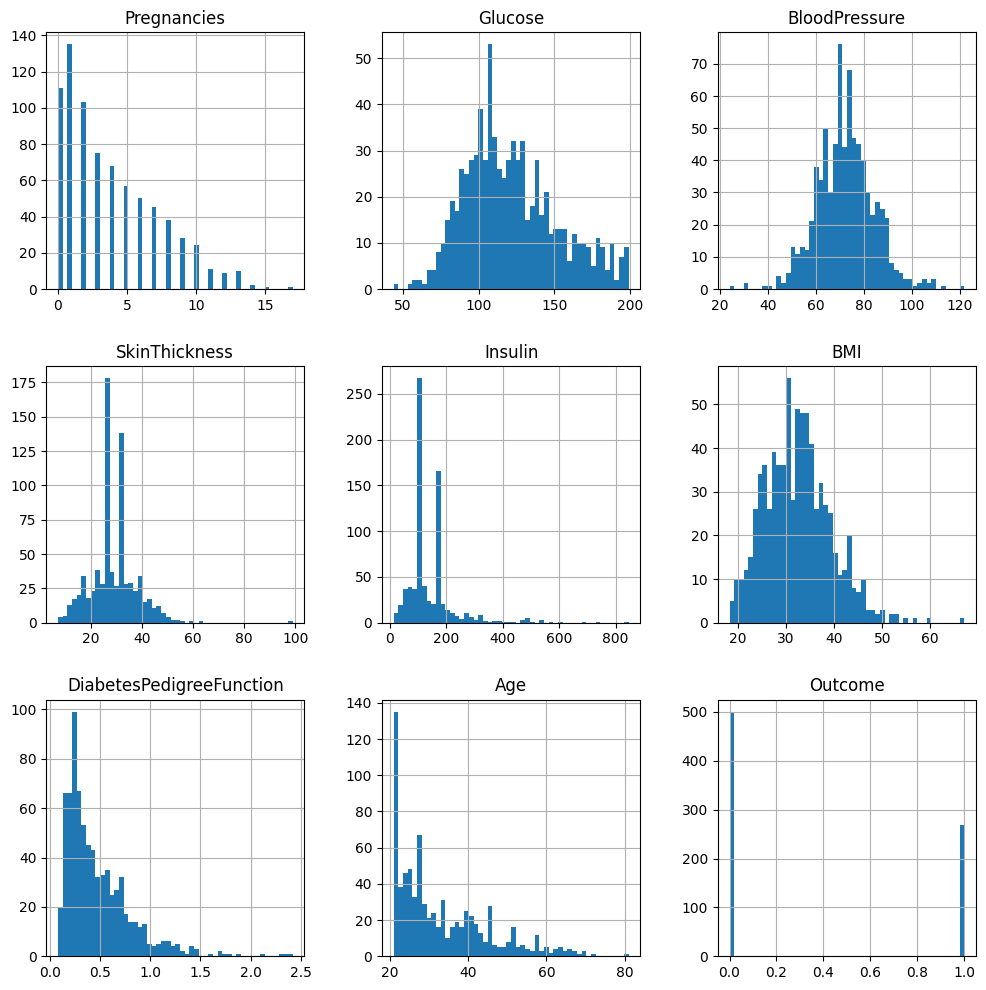

In [ ]:
# Membuat Histogram untuk masing-masing fitur dalam dataset yang telah dibersihkan
df.hist(bins=50, figsize=(12,12))
plt.show()

**Penjelasan**

Pada Histogram ini menunjukkan data numerik untuk masing-masing fitur dalam dataset yang telah dibersihkan melalui proses penggantian data nol dengan median masing-masing outcome.

In [ ]:
# Describe Fitur Numerik
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.677083,72.389323,29.089844,141.753906,32.434635,0.471876,33.240885,0.348958
std,3.369578,30.464161,12.106039,8.890820,89.100847,6.880498,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,102.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,28.000000,102.500000,32.050000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,169.500000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Menampilkan 5 baris teratas dalam dataset
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## Feature Selection

**Insight**

Pada bagian Feature Selection ini kami melakukan pemilihan fitur yang akan digunakan untuk pembuatan model berdasarkan korelasi antara fitur dengan outcome yang menjadi target. Kemudian kami memilih fitur yang korelasinya dengan outcome lebih dari 0.3, yaitu Glucose, Insulin, dan BMI.

In [ ]:
# Menentukan X dan y
X = df.drop(columns=['Outcome'])  # Menghapus kolom target
y = df['Outcome']  # Kolom target yang ingin diprediksi

# Menampilkan dimensi dataset
print("Dimensi X (fitur):", X.shape)
print("Dimensi y (target):", y.shape)

Dimensi X (fitur): (768, 8)
Dimensi y (target): (768,)


**Insight**

Kode ini digunakan untuk menampilkan korelasi antara fitur numerik dengan variabel target (Outcome) dalam dataset menggunakan diagram batang (barplot) dari Seaborn.

<ipython-input-347-82244cfa282c>:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



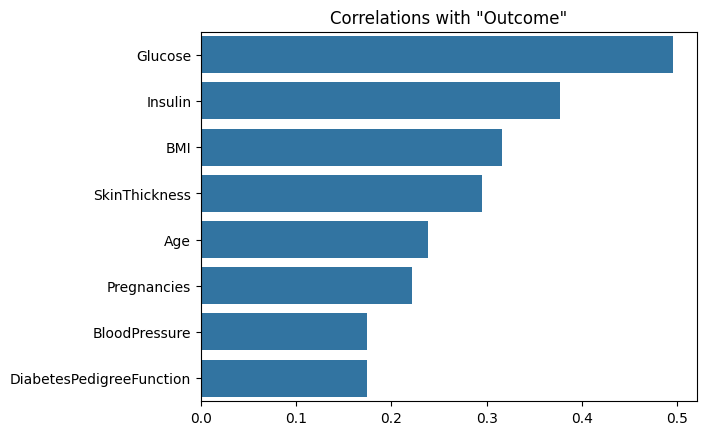

In [ ]:
# Correlations
limit = -1.0 #Menentukan batas korelasi (filter fitur berdasarkan nilai korelasi)

data = df.corr()["Outcome"].sort_values(ascending=False) #Menghitung korelasi seluruh fitur dengan Outcome
indices = data.index # Menyimpan fitur dengan korelasi lebih besar dari limit
labels = []
corr = []
for i in range(1, len(indices)):
    if data[indices[i]]>limit:
        labels.append(indices[i])
        corr.append(data[i])
sns.barplot(x=corr, y=labels) #Menampilkan diagram batang hubungan fitur dengan Outcome
plt.title('Correlations with "Outcome"')
plt.show()

In [ ]:
# Hitung korelasi dengan Outcome
data = df.corr()["Outcome"].sort_values(ascending=False)

# Tentukan threshold korelasi (misalnya, > 0.3)
limit = 0.3

# Pilih fitur berdasarkan threshold
selected_features = data[abs(data) > limit].index.tolist()

# Hilangkan 'Outcome' dari daftar fitur jika ada
selected_features = [feature for feature in selected_features if feature != 'Outcome']

# Tampilkan fitur yang dipilih
print("Fitur terpilih berdasarkan korelasi (> 0.3):", selected_features)

# Buat dataset baru dengan fitur yang dipilih
X_selected = df[selected_features]
print("Dimensi dataset setelah seleksi:", X_selected.shape)

Fitur terpilih berdasarkan korelasi (> 0.3): ['Glucose', 'Insulin', 'BMI']
Dimensi dataset setelah seleksi: (768, 3)


### Normalisasi
**Insight**

Pada tahapan normalisasi data, kami menggunakan bantuan dari library scikit learn untuk melakukan normalisasi dengan StandardScaler. Proses ini penting untuk memastikan bahwa fitur-fitur dengan rentang nilai yang berbeda (misalnya, Glucose yang berkisar 0-199 dan BMI yang berkisar 0-67) tidak mendominasi model machine learning hanya karena perbedaan skala.

In [ ]:
# Import library untuk normalisasi
from sklearn.preprocessing import StandardScaler

# Dataset hasil seleksi fitur (dari kode sebelumnya)
X_selected = X[selected_features]

# Inisialisasi StandardScaler
scaler = StandardScaler()

# Lakukan normalisasi pada data yang sudah dipilih
X_normalized = scaler.fit_transform(X_selected)

# Konversi kembali ke DataFrame untuk memudahkan analisis (opsional)
X_normalized_df = pd.DataFrame(X_normalized, columns=selected_features)

# Tampilkan beberapa baris data setelah normalisasi
print("Data setelah normalisasi (5 baris pertama):")
print(X_normalized_df.head())

# Tampilkan statistik dasar untuk memastikan normalisasi berhasil (mean ~ 0, std ~ 1)
print("\nStatistik setelah normalisasi:")
print(X_normalized_df.describe())

Data setelah normalisasi (5 baris pertama):
    Glucose   Insulin       BMI
0  0.864625  0.311604  0.169483
1 -1.204727 -0.440843 -0.848549
2  2.014265  0.311604 -1.328478
3 -1.073339 -0.536303 -0.630399
4  0.503310  0.294758  1.551096

Statistik setelah normalisasi:
            Glucose       Insulin           BMI
count  7.680000e+02  7.680000e+02  7.680000e+02
mean   1.480297e-16 -3.469447e-18  1.318390e-16
std    1.000652e+00  1.000652e+00  1.000652e+00
min   -2.551447e+00 -1.434747e+00 -2.070186e+00
25%   -7.202356e-01 -4.408430e-01 -7.176590e-01
50%   -1.536274e-01 -4.408430e-01 -5.593870e-02
75%    6.100618e-01  3.116039e-01  6.057816e-01
max    2.539814e+00  7.909072e+00  5.041489e+00


## Pembuatan Model

### Train-Test Split Data
**Insight**

Pada langkah pembuatan model di bagian Train-Test Split Data ini kami melakukan pembagian dataset menjadi 70% untuk data latih, dan 30% untuk data uji. Total data uji adalah 231 data dengan 3 fitur

In [ ]:
# Data yang sudah dinormalisasi
X_normalized = scaler.fit_transform(X_selected)

# Pisahkan data menjadi train dan test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

print("Dimensi data pelatihan:", X_train.shape)
print("Dimensi data pengujian:", X_test.shape)

Dimensi data pelatihan: (537, 3)
Dimensi data pengujian: (231, 3)


### Cross-Validation
**Insight**

Pada bagian cross-validation ini kami melakukan pemeriksaan awal performa dan keandalan model untuk memastikan model tidak hanya jago mengklasifikasikan satu jenis outcome.

In [ ]:
# Inisialisasi model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Lakukan 5-Fold Cross Validation pada data pelatihan
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

# Tampilkan hasil
print("Skor Cross Validation (5-Fold):", cv_scores)
print("Rata-rata skor CV:", cv_scores.mean())
print("Standar deviasi skor CV:", cv_scores.std())

Skor Cross Validation (5-Fold): [0.86111111 0.85185185 0.81308411 0.85046729 0.89719626]
Rata-rata skor CV: 0.8547421253028731
Standar deviasi skor CV: 0.026851203457994317


### Random Forest
**Insight**

Pada bagian ini, kami membuat kode untuk pembuatan model random forest classifier dengan bantuan library Scikit-Learn. Setelah itu kami melakuakn  pengukuran metrik evaluasi dengan Accuracy, Precision, Recall, dan F1-Score.

In [ ]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [1800]
max_features = [2, 3]

In [ ]:
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)

In [ ]:
best_model = grid_search.fit(X_train, y_train)

In [ ]:
rf_pred=best_model.predict(X_test)

Classification Report is:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       151
           1       0.80      0.76      0.78        80

    accuracy                           0.85       231
   macro avg       0.84      0.83      0.84       231
weighted avg       0.85      0.85      0.85       231


 F1:
 0.782051282051282

 Precision score is:
 0.8026315789473685

 Recall score is:
 0.7625

 Confusion Matrix:


Confusion Matrix:



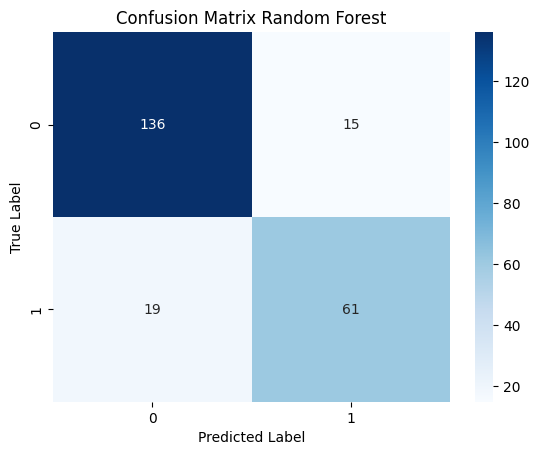

In [ ]:
print("Classification Report is:\n",classification_report(y_test,rf_pred))
print("\n F1:\n",f1_score(y_test,rf_pred)) # Changed knn_pred to rf_pred
print("\n Precision score is:\n",precision_score(y_test,rf_pred)) # Changed knn_pred to rf_pred
print("\n Recall score is:\n",recall_score(y_test,rf_pred)) # Changed knn_pred to rf_pred
print("\n Confusion Matrix:\n")

# Tampilkan Confusion Matrix sebagai heatmap
print("\nConfusion Matrix:\n")
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Naive Bayes
**Insight**

Pada bagian ini, kami membuat kode untuk pembuatan model Naive Bayes dengan bantuan library Scikit-Learn. Setelah itu kami melakuakn  pengukuran metrik evaluasi dengan Accuracy, Precision, Recall, dan F1-Score.

Classification Report untuk Naive Bayes:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       151
           1       0.65      0.56      0.60        80

    accuracy                           0.74       231
   macro avg       0.72      0.70      0.71       231
weighted avg       0.74      0.74      0.74       231


F1 Score:
0.6040268456375839

Precision Score:
0.6521739130434783

Recall Score:
0.5625

Confusion Matrix:



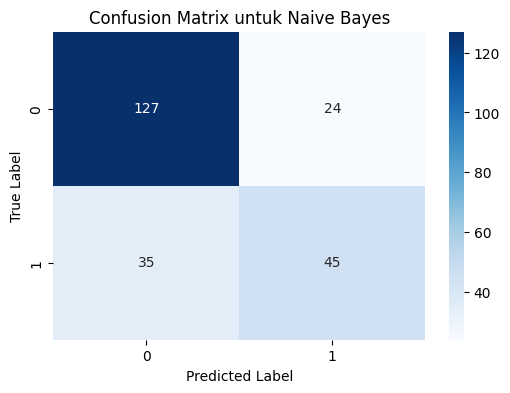

In [ ]:
# Inisialisasi model Naive Bayes (GaussianNB)
nb_model = GaussianNB()

# Latih model dengan data pelatihan
nb_model.fit(X_train, y_train)

# Lakukan prediksi pada data pengujian
nb_pred = nb_model.predict(X_test)

# Evaluasi model
print("Classification Report untuk Naive Bayes:")
print(classification_report(y_test, nb_pred))
print("\nF1 Score:")
print(f1_score(y_test, nb_pred))
print("\nPrecision Score:")
print(precision_score(y_test, nb_pred))
print("\nRecall Score:")
print(recall_score(y_test, nb_pred))
print("\nConfusion Matrix:\n")

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix untuk Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### J48 Decision Tree

**Insight**

Pada bagian ini, kami membuat kode untuk pembuatan model J48 Decision Tree dengan bantuan library Scikit-Learn. Setelah itu kami melakuakn  pengukuran metrik evaluasi dengan Accuracy, Precision, Recall, dan F1-Score.

Classification Report untuk J48 Decision Tree:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       151
           1       0.79      0.76      0.78        80

    accuracy                           0.85       231
   macro avg       0.83      0.83      0.83       231
weighted avg       0.85      0.85      0.85       231


F1 Score:
0.7770700636942676

Precision Score:
0.7922077922077922

Recall Score:
0.7625

Confusion Matrix:



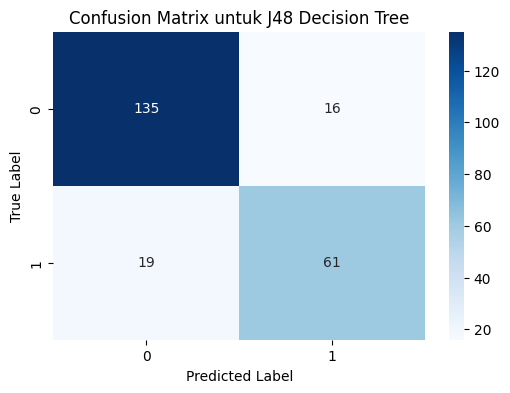

In [ ]:
# Inisialisasi model Decision Tree (J48 / C4.5)
j48_model = DecisionTreeClassifier(criterion='entropy')  # Menggunakan 'entropy' untuk mirip dengan J48

# Latih model dengan data pelatihan
j48_model.fit(X_train, y_train)

# Lakukan prediksi pada data pengujian
j48_pred = j48_model.predict(X_test)

# Evaluasi model
print("Classification Report untuk J48 Decision Tree:")
print(classification_report(y_test, j48_pred))
print("\nF1 Score:")
print(f1_score(y_test, j48_pred))
print("\nPrecision Score:")
print(precision_score(y_test, j48_pred))
print("\nRecall Score:")
print(recall_score(y_test, j48_pred))
print("\nConfusion Matrix:\n")

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, j48_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix untuk J48 Decision Tree')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Hasil dan Analisis

**Insight**

Untuk bagian ini kami menampilkan ROC Curve yang merupakan kurva yang bisa mengevaluasi kemampuan model dalam membedakan kelas.
- Random Forest adalah model terbaik dalam membedakan diabetes dan non-diabetes (AUC tertinggi).
- Naive Bayes memiliki performa terendah (AUC terendah).
- J48 Decision Tree berada di tengah, lebih baik dari Naive Bayes tetapi kalah dari Random Forest.

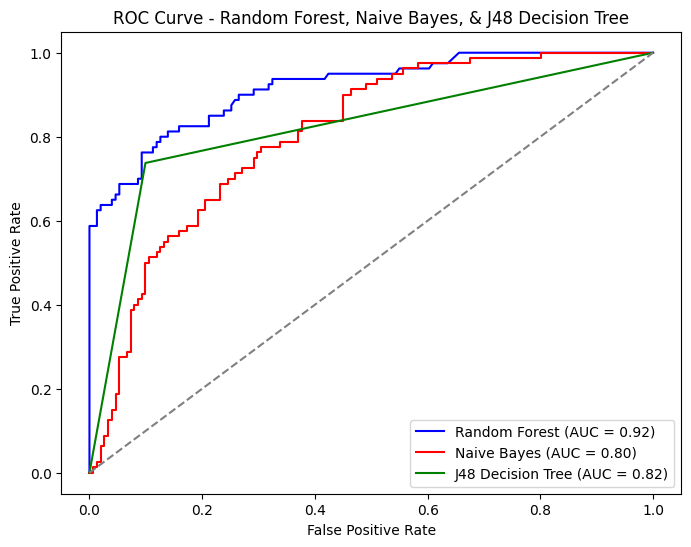

In [363]:
# Pastikan model Random Forest (best_model) sudah dilatih dan X_test, y_test tersedia
# Menghitung probabilitas prediksi untuk kelas positif pada Random Forest
y_probs_rf = best_model.predict_proba(X_test)[:, 1]

# Menghitung ROC Curve untuk Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
auc_score_rf = auc(fpr_rf, tpr_rf)

# Melatih model Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Menghitung probabilitas prediksi untuk kelas positif pada Naive Bayes
y_probs_nb = nb_model.predict_proba(X_test)[:, 1]

# Menghitung ROC Curve untuk Naive Bayes
fpr_nb, tpr_nb, _ = roc_curve(y_test, y_probs_nb)
auc_score_nb = auc(fpr_nb, tpr_nb)

# Inisialisasi dan melatih model J48 Decision Tree
j48_model = DecisionTreeClassifier(criterion='entropy')  # Menggunakan 'entropy' untuk J48
j48_model.fit(X_train, y_train)

# Menghitung probabilitas prediksi untuk kelas positif pada J48 Decision Tree
y_probs_j48 = j48_model.predict_proba(X_test)[:, 1]

# Menghitung ROC Curve untuk J48 Decision Tree
fpr_j48, tpr_j48, _ = roc_curve(y_test, y_probs_j48)
auc_score_j48 = auc(fpr_j48, tpr_j48)

# Plot ROC Curve untuk ketiga model
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_score_rf:.2f})", color='blue')
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_score_nb:.2f})", color='red')
plt.plot(fpr_j48, tpr_j48, label=f"J48 Decision Tree (AUC = {auc_score_j48:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle="--", color='gray')  # Garis diagonal sebagai referensi
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest, Naive Bayes, & J48 Decision Tree")
plt.legend()
plt.show()